In [ ]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import cv2
import glob
import matplotlib.pyplot as plt
from keras import backend as K
import keras
import matplotlib.pyplot as plt
import gdal
# import pydensecrf.densecrf as dcrf\
import glob
import tifffile as tif

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred): 
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def IOU(true, pred): 
    tresholds = [0.5 + (i*.05)  for i in range(10)]
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    truePositiveMask = castB(true1 * pred1)

    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    trueNegatives = (1-true1) * (1 - pred1) 
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])
  
def focal_loss(gamma=2, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):#with tensorflow
        eps = 1e-12
        y_pred=K.clip(y_pred,eps,1.-eps)#improve the stability of the focal loss and see issues 1 for more information
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def unet(pretrained_weights = None, input_size = (256,256,3)):
    inputs = Input(input_size)
    
    #inpu1=DownSampling2D(size = (2,2))
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [IOU])

    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

Using TensorFlow backend.


Data loading


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")


In [ ]:
DATA_DIR =  "/content/drive/My Drive/Village Finder"


In [ ]:

x_train_dir = os.path.join(DATA_DIR, 'patches/images')
y_train_dir = os.path.join(DATA_DIR, 'patches_gt/images')

x_valid_dir = os.path.join(DATA_DIR, 'val_patches/images')
y_valid_dir = os.path.join(DATA_DIR, 'val_gt/images')


x_train_dir

'/content/drive/My Drive/Village Finder/patches/images'

In [ ]:
import gdal
from PIL import Image
# helper function for data visualization
def visualize(img_path='', **images):

    """PLot images in one row."""
    plt.figure(figsize=(16, 5))

    if img_path != '':
        data_path = os.path.join(img_path,'*g')
        files = glob.glob(data_path)
        n = len(files)
        i = 0
        num_img_dis=6
        for filename in files[:num_img_dis]:
            # img = cv2.imread(filename)
            img = Image.open(filename)
            i += 1
            plt.subplot(1, num_img_dis+1, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(filename.split('ges/')[-1].title(), fontsize=9 )
            plt.imshow(img)
        plt.show()
    else:
        print("we here!")
        n = len(images)
        for i, (name, image) in enumerate(images.items()):
            #print(name)
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(name)
            plt.imshow( image )
        plt.show()

#visualize(img_path=x_train_dir);

In [ ]:
import numpy as np

directory = "/content/drive/My Drive/"

In [ ]:
processed_folder = os.path.join(directory, "processed")
if os.path.isdir(processed_folder + "/TrainingImages") != True:
    print("making processed folder", processed_folder+ "/TrainingImages")
    os.mkdir(processed_folder)
    os.mkdir(processed_folder + "/TrainingImages")

originalImages = os.listdir(x_train_dir)
dim = (256, 256) #(w,h)
count =0
for index,image in enumerate(originalImages):
    count +=1 
    readImage = cv2.imread(x_train_dir+"/" + str(image))
    #plt.imshow(readImage)
    resizedImage = cv2.resize(readImage, dim, interpolation=cv2.INTER_AREA)
    imageName = str(image).split(".")[0]
    #Converting to .png and Storing resized image to a directory
    cv2.imwrite(processed_folder + "/TrainingImages/" + imageName + ".png", resizedImage)
    if count % 100 == 0:        
        print("Reading Image : " + str(image) +" with Index : "+str(index))
        print("Shape of resized Image is : ", resizedImage.shape)
        print("Resized and Stored Image : " + str(image) +" with Index : "+str(index))


making processed folder /content/drive/My Drive/processed/TrainingImages
Reading Image : 0049_79.jpg with Index : 99
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0049_79.jpg with Index : 99
Reading Image : 0051_25.jpg with Index : 199
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0051_25.jpg with Index : 199
Reading Image : 0052_60.jpg with Index : 299
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0052_60.jpg with Index : 299
Reading Image : 0053_56.jpg with Index : 399
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0053_56.jpg with Index : 399
Reading Image : 0054_67.jpg with Index : 499
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0054_67.jpg with Index : 499
Reading Image : 0056_2.jpg with Index : 599
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0056_2.jpg with Index : 599
Reading Image : 0057_59.jpg with Index : 699
Shape of resized Image

In [ ]:
processed_folder = os.path.join(directory,"processed")
if os.path.isdir(processed_folder + "/ValdImages") != True:
    print("making processed folder", processed_folder+ "/ValdImages")
    os.mkdir(processed_folder + "/ValdImages")

originalImages = os.listdir(x_valid_dir)
dim = (256, 256) #(w,h)
count = 0
for index,image in enumerate(originalImages):
    count +=1 
    readImage = cv2.imread(x_valid_dir+"/" + str(image))
    #plt.imshow(readImage)
    resizedImage = cv2.resize(readImage, dim, interpolation=cv2.INTER_AREA)
    imageName = str(image).split(".")[0]
    #Converting to .png and Storing resized image to a directory
    cv2.imwrite(processed_folder + "/ValdImages/" + imageName + ".png", resizedImage)
    if count % 100 == 0:
        print("Reading Image : " + str(image) +" with Index : "+str(index))
        print("Shape of resized Image is : ", resizedImage.shape)
        print("Resized and Stored Image : " + str(image) +" with Index : "+str(index))

making processed folder /content/drive/My Drive/processed/ValdImages
Reading Image : 0001_27.jpg with Index : 33
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0001_27.jpg with Index : 33
Reading Image : 0002_51.jpg with Index : 133
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0002_51.jpg with Index : 133
Reading Image : 0003_72.jpg with Index : 233
Shape of resized Image is :  (256, 256, 3)
Resized and Stored Image : 0003_72.jpg with Index : 233


In [ ]:
processed_folder = os.path.join(directory,"processed")
if os.path.isdir(processed_folder + "/trainingMasks") != True:
    print("making processed folder", processed_folder+ "/trainingMasks")
    os.mkdir(processed_folder + "/trainingMasks")

maskImagesTrain = os.listdir(y_train_dir)
dim = (256, 256) #(w,h)
count =0 
for index,image in enumerate(maskImagesTrain):
    count += 1
    readImage = cv2.imread(y_train_dir+"/" + str(image),0)
    #plt.imshow(readImage)
    resizedImage = cv2.resize(readImage, dim, interpolation=cv2.INTER_AREA)
    imageName = str(image).split(".")[0]
    (thresh, im_bw) = cv2.threshold(resizedImage, 128, 255, cv2.THRESH_BINARY)
    #Converting to .png and Storing resized image to a directory
    cv2.imwrite(processed_folder + "/trainingMasks/" + imageName + ".png", im_bw)
    if count % 100 == 0:
        print("Reading Image : " + str(image) +" with Index : "+str(index))
        print("Shape of resized Image is : ", resizedImage.shape)
        print("Resized and Stored Image : " + str(image) +" with Index : "+str(index))



making processed folder /content/drive/My Drive/processed/trainingMasks
Reading Image : 0049_26.tif with Index : 99
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0049_26.tif with Index : 99
Reading Image : 0051_22.tif with Index : 199
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0051_22.tif with Index : 199
Reading Image : 0052_46.tif with Index : 299
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0052_46.tif with Index : 299
Reading Image : 0053_57.tif with Index : 399
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0053_57.tif with Index : 399
Reading Image : 0055_16.tif with Index : 499
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0055_16.tif with Index : 499
Reading Image : 0056_31.tif with Index : 599
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0056_31.tif with Index : 599
Reading Image : 0057_33.tif with Index : 699
Shape of resized Image is :  (256, 256)

In [ ]:
processed_folder = os.path.join(directory,"processed")
if os.path.isdir(processed_folder + "/valdMasks") != True:
    print("making processed folder", processed_folder+ "/valdMasks")
    os.mkdir(processed_folder + "/valdMasks")

maskImagesTrain = os.listdir(y_valid_dir)
dim = (256, 256) #(w,h)
count = 0
for index,image in enumerate(maskImagesTrain):
    count+=1
    readImage = cv2.imread(y_valid_dir+"/" + str(image),0)
    #plt.imshow(readImage)
    resizedImage = cv2.resize(readImage, dim, interpolation=cv2.INTER_AREA)
    imageName = str(image).split(".")[0]
    (thresh, im_bw) = cv2.threshold(resizedImage, 128, 255, cv2.THRESH_BINARY)
    #Converting to .png and Storing resized image to a directory
    cv2.imwrite(processed_folder + "/valdMasks/" + imageName + ".png", im_bw)
    if count % 100 == 0:
        print("Reading Image : " + str(image) +" with Index : "+str(index))
        print("Shape of resized Image is : ", resizedImage.shape)
        print("Resized and Stored Image : " + str(image) +" with Index : "+str(index))



making processed folder /content/drive/My Drive/processed/valdMasks
Reading Image : 0002_58.tif with Index : 99
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0002_58.tif with Index : 99
Reading Image : 0003_31.tif with Index : 199
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0003_31.tif with Index : 199
Reading Image : 0004_63.tif with Index : 299
Shape of resized Image is :  (256, 256)
Resized and Stored Image : 0004_63.tif with Index : 299


In [ ]:
processed_folder = os.path.join(directory,"processed")
train_images = []
print(processed_folder+"/TrainingImages/")
originalImages = os.listdir(processed_folder+"/TrainingImages/")
originalImages = sorted(originalImages)

for index,image in enumerate(originalImages):
    if index%100==0:
        print("Image number : " +str(index) )
    img = Image.open(processed_folder+"/TrainingImages/" + str(image))
    arr = np.array(img)
    train_images.append(arr)

print("done!")

In [ ]:
train_masks = []
maskImages = os.listdir(processed_folder+"/trainingMasks/")
maskImages = sorted(maskImages)
for index,image in enumerate(maskImages):
    if index%100==0:
        print("images",index)
    img = Image.open(processed_folder+"/trainingMasks/" + str(image))
    arr = np.array(img)
    arr = np.expand_dims(arr, -1)
    train_masks.append(arr)

print("done!")

In [ ]:
print(len(maskImages), len(originalImages))
maskImages[:5], originalImages[:5]

3566 3566


(['0004_80.png', '0004_81.png', '0005_1.png', '0005_10.png', '0005_11.png'],
 ['0004_80.png', '0004_81.png', '0005_1.png', '0005_10.png', '0005_11.png'])

In [ ]:
processed_folder = os.path.join(directory,"processed")
test_images = []
print(processed_folder+"/ValdImages/")
testImages = os.listdir(processed_folder+"/ValdImages/")
testImages = sorted(testImages)

for index,image in enumerate(testImages):
    if index%100==0:
        print("Image number : " +str(index) )
    img = Image.open(processed_folder+"/ValdImages/" + str(image))
    arr = np.array(img)
    test_images.append(arr)

print("done!")

In [ ]:
test_masks = []
test_maskImages = os.listdir(processed_folder+"/valdMasks/")
test_maskImages = sorted(test_maskImages)
for index,image in enumerate(test_maskImages):
    if index%100==0:
        print("masks ",index)
    img = Image.open(processed_folder+"/valdMasks/" + str(image))
    arr = np.array(img)
    arr = np.expand_dims(arr, -1)
    test_masks.append(arr)

print("done!")

In [ ]:
imgs_train = np.array(train_images)
imgs_mask_train = np.array(train_masks)

print(imgs_train.shape)
print(imgs_mask_train.shape)
 
imgs_train = imgs_train.astype('float32')

mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization



(3566, 256, 256, 3)
(3566, 256, 256, 1)


In [ ]:
imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255  # scale masks to [0, 1]

In [ ]:
#normalizing test data with mean and std, and converting masks to [0,1] range
imgs_test = np.array(test_images)
imgs_mask_test = np.array(test_masks)

print(imgs_test.shape)
print(imgs_mask_test.shape)
 
imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

imgs_mask_test = imgs_mask_test.astype('float32')
imgs_mask_test /= 255  


(322, 256, 256, 3)
(322, 256, 256, 1)


In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
tf.keras.backend.clear_session()
print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = unet()

tf.keras.utils.plot_model(
    model,
    to_file="model1.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=128,
)


model_checkpoint = ModelCheckpoint('weights123.h5', monitor='val_loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='tensorboard1/', write_graph=True, write_images=True)

In [ ]:
print('starting model...')
print('*'*30)
history =  model.fit(imgs_train, imgs_mask_train, batch_size=8, epochs=1, 
                     verbose=2, shuffle=True, 
                     validation_split=0.2,callbacks=[model_checkpoint, tensorboard])


starting model...
******************************
Train on 2852 samples, validate on 714 samples
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.462055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 126s - loss: 0.4187 - IOU: 0.6355 - val_loss: 0.2841 - val_IOU: 0.8806


In [ ]:
print('Continuing training model...')
print('*'*30)
history =  model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=15, 
                     verbose=2, shuffle=True, 
                     validation_split=0.2,callbacks=[model_checkpoint, tensorboard])

Continuing training model...
******************************
Train on 2852 samples, validate on 714 samples
Epoch 1/15
 - 99s - loss: 0.0349 - IOU: 0.8647 - val_loss: 0.0973 - val_IOU: 0.8654
Epoch 2/15
 - 99s - loss: 0.0229 - IOU: 0.8997 - val_loss: 0.0953 - val_IOU: 0.8467
Epoch 3/15
 - 99s - loss: 0.0195 - IOU: 0.9120 - val_loss: 0.1268 - val_IOU: 0.8792
Epoch 4/15
 - 99s - loss: 0.0175 - IOU: 0.9194 - val_loss: 0.1502 - val_IOU: 0.8577
Epoch 5/15
 - 99s - loss: 0.0156 - IOU: 0.9293 - val_loss: 0.1223 - val_IOU: 0.8772
Epoch 6/15
 - 99s - loss: 0.0151 - IOU: 0.9292 - val_loss: 0.1732 - val_IOU: 0.8641
Epoch 7/15
 - 99s - loss: 0.0148 - IOU: 0.9295 - val_loss: 0.1501 - val_IOU: 0.8602
Epoch 8/15
 - 99s - loss: 0.0142 - IOU: 0.9324 - val_loss: 0.1323 - val_IOU: 0.8663
Epoch 9/15
 - 99s - loss: 0.0135 - IOU: 0.9335 - val_loss: 0.1412 - val_IOU: 0.8671
Epoch 10/15
 - 99s - loss: 0.0135 - IOU: 0.9349 - val_loss: 0.1272 - val_IOU: 0.8212
Epoch 11/15
 - 99s - loss: 0.0138 - IOU: 0.9308 - va

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()

with open(directory+"/storedModel.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(directory+"/model_weights.h5")

In [ ]:
from keras.models import model_from_json
from keras.models import load_model
# load json and create model
json_file = open(directory+"/storedModel.json", 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(directory+"/model_weights.h5")
print("Loaded model from disk")

loaded_model.save('notSoFinal.hdf5')
loaded_model=load_model('notSoFinal.hdf5')

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('thirdTry.h5', monitor='val_loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='tensorboard/', write_graph=True, write_images=True)
loaded_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [IOU])
history =  loaded_model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=5, 
                     verbose=1, shuffle=True, 
                     validation_split=0.25,callbacks=[model_checkpoint, tensorboard])

Train on 2674 samples, validate on 892 samples
Epoch 1/5
2674/2674 [==============================] - 105s 39ms/step - loss: 0.0269 - IOU: 0.8905 - val_loss: 0.1023 - val_IOU: 0.8344
Epoch 2/5
2674/2674 [==============================] - 96s 36ms/step - loss: 0.0272 - IOU: 0.8863 - val_loss: 0.0793 - val_IOU: 0.8763
Epoch 3/5
2674/2674 [==============================] - 96s 36ms/step - loss: 0.0183 - IOU: 0.9194 - val_loss: 0.1067 - val_IOU: 0.8797
Epoch 4/5
2674/2674 [==============================] - 96s 36ms/step - loss: 0.0188 - IOU: 0.9118 - val_loss: 0.1286 - val_IOU: 0.8670
Epoch 5/5
2674/2674 [==============================] - 96s 36ms/step - loss: 0.0185 - IOU: 0.9191 - val_loss: 0.0847 - val_IOU: 0.8628


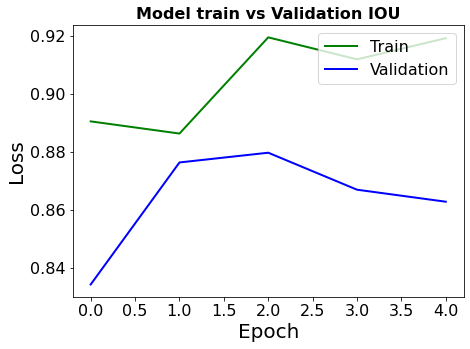

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.history['IOU'], linewidth=2, color='g')                   #visualising training and validation loss curves
plt.plot(history.history['val_IOU'], linewidth=2, color='b')
plt.title('Model train vs Validation IOU', fontsize=16, fontweight="bold")
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

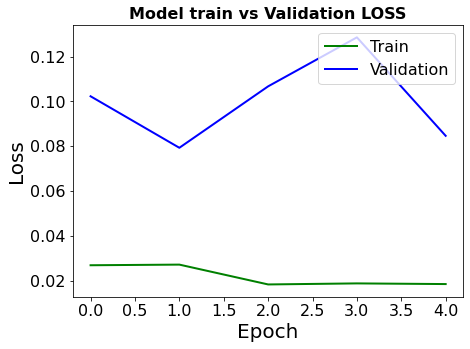

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], linewidth=2, color='g')                   #visualising training and validation loss curves
plt.plot(history.history['val_loss'], linewidth=2, color='b')
plt.title('Model train vs Validation LOSS', fontsize=16, fontweight="bold")
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
test_predicted_masks = loaded_model.predict(imgs_test, verbose=1)

322/322 [==============================] - 12s 37ms/step


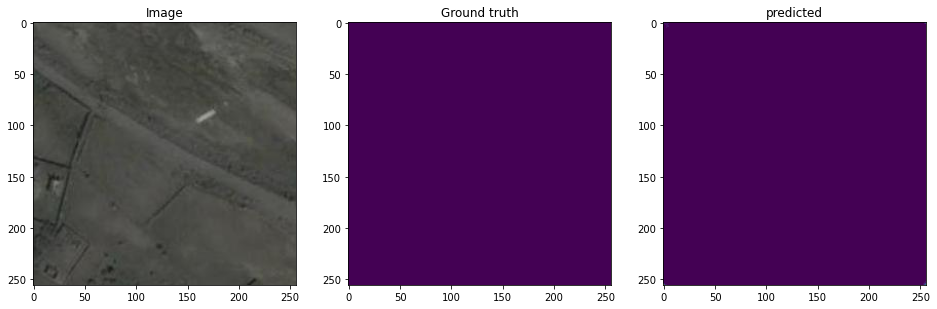

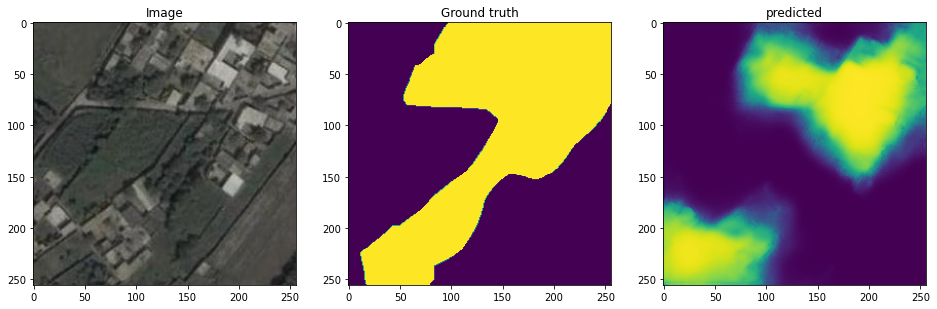

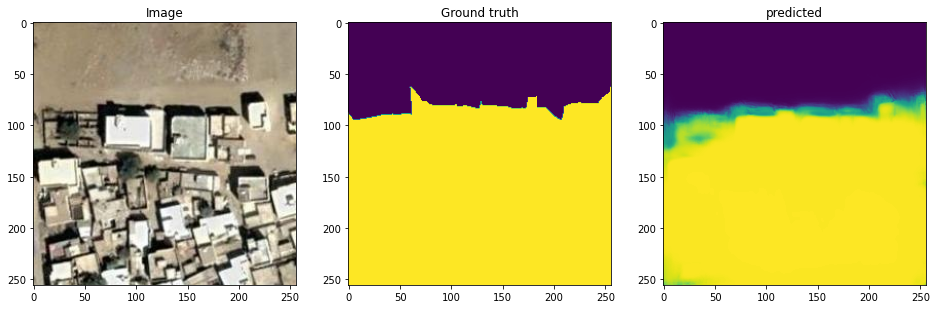

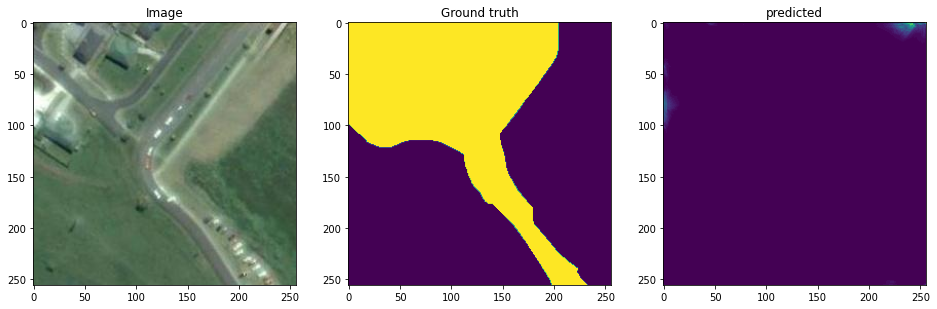

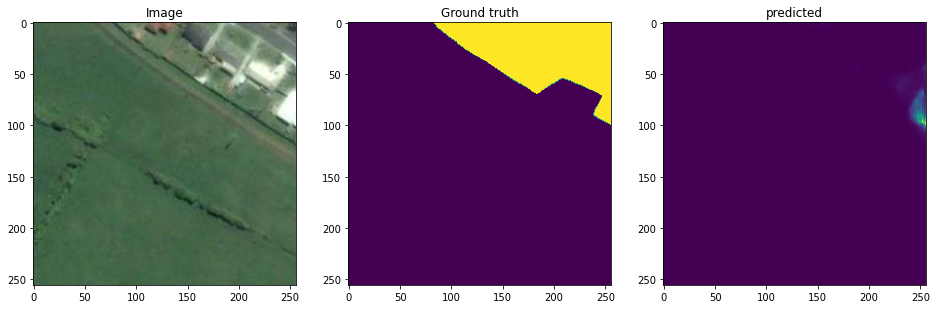

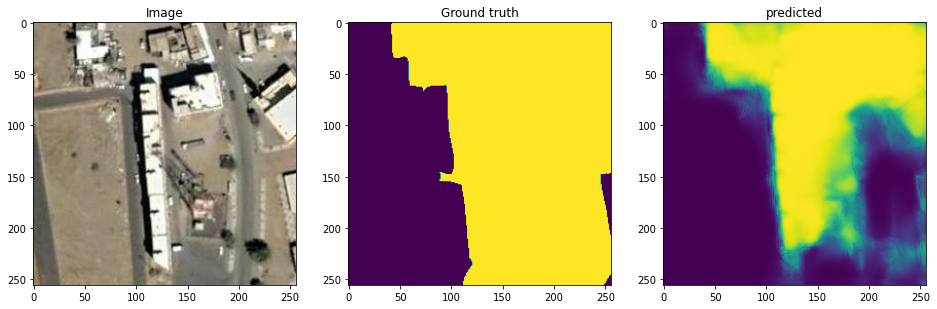

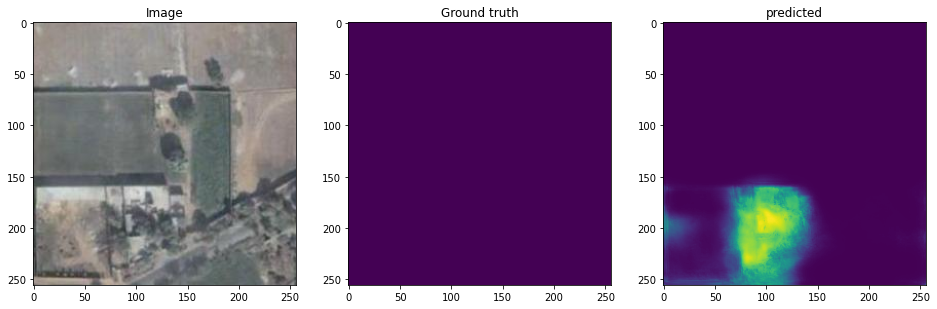

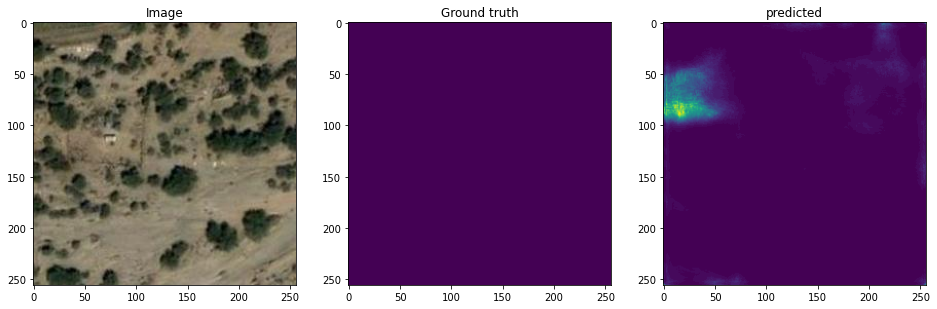

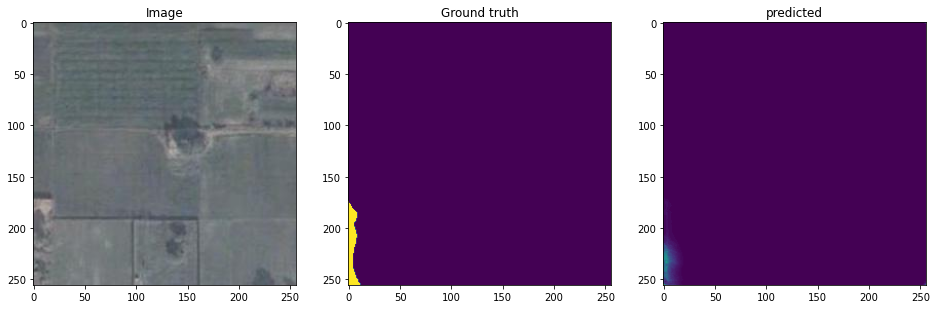

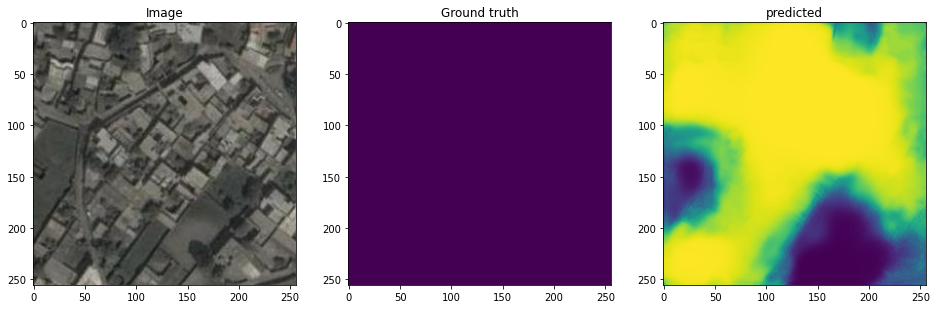

In [ ]:
import random

randomlist = random.sample(range(0, len(test_predicted_masks)), 10)

for i in randomlist:
    org = test_images[i]
    pred = test_predicted_masks[i]
    gt = test_masks[i]
    pred = (pred * 255).astype(np.uint8)
    pred = np.squeeze(pred,-1)
    gt = np.squeeze(gt,-1)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.title("Image")
    plt.imshow(org.astype(np.uint8))
    plt.subplot(132)
    plt.title("Ground truth")
    plt.imshow(gt)
    plt.subplot(133)
    plt.title("predicted")
    plt.imshow(pred)
    plt.show()
